In [103]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2
import sklearn as sk
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow import keras
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [89]:
data_path = "/Users/bradleyherctt/Documents/GitHub/face-mask-recognition/dataset"
categories = ["with_mask", "without_mask"]

data = []
labels = []

In [90]:
# split into 2 groups
# 20% testing, 80% training
mask_imgs = os.listdir(data_path + "/" + categories[0])
length_mask = len(mask_imgs)
test_mask = []
train_mask = []
i = 0

for img in mask_imgs: 
    i += 1
    if i - 1  <= 0.8 * length_mask:
        train_mask.append(img)
    else: 
        test_mask.append(img)

nomask_imgs = os.listdir(data_path + "/" + categories[1])
length_nomask = len(nomask_imgs)
test_nomask = []
train_nomask = []
i = 0

for img in nomask_imgs:
    i += 1
    if i - 1 <= 0.8 * length_nomask:
        train_nomask.append(img)
    else:
        test_nomask.append(img)

print("All images partitioned into testing (20%) & training (80%) categories successfully.")

All images partitioned into testing (20%) & training (80%) categories successfully.


In [91]:
init_lr = 1e-4
epochs = 5
batch_size = 32

In [92]:

for x in categories:
    local_path = os.path.join(data_path, x)
    for img in os.listdir(local_path):
        img_path = os.path.join(local_path, img)
        new_img = load_img(img_path, target_size=(128, 128))
        new_img = img_to_array(new_img)
        new_img = preprocess_input(new_img)

        data.append(new_img)
        labels.append(x)

In [93]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [94]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [95]:
# no need for data augmentations, dataset already augmented
# imagenet pre-trained model specifically for images
# 
base_mdl = tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(128, 128, 3)))

# 
head_mdl = base_mdl.output
head_mdl = AveragePooling2D(pool_size=(3, 3))(head_mdl)
head_mdl = Flatten(name="flatten")(head_mdl)
# 128 neurons
head_mdl = Dense(128, activation="relu")(head_mdl)
# helps prevent overfitting
head_mdl = Dropout(0.5)(head_mdl)
# 2 layers, with/without mask
head_mdl = Dense(2, activation="softmax")(head_mdl)

In [96]:
# place head on top of base
model = Model(inputs = base_mdl.input, outputs = head_mdl)

In [97]:
for i in base_mdl.layers:
    i.trainable = False

In [98]:
print("Compiling model...")
opt = Adam(learning_rate = init_lr, decay = init_lr / epochs) # Adam optimizer being used
model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ["accuracy"])

print("Training head...")
F = model.fit(x=trainX, y=trainY, batch_size = batch_size, 
    steps_per_epoch = len(trainX) // batch_size,
    validation_data = (testX, testY),
    validation_steps = len(testX) // batch_size,
    epochs = epochs)

Compiling model...
Training head...
Epoch 1/5
149/149 [==============================] - 86s 559ms/step - loss: 0.2435 - accuracy: 0.9241 - val_loss: 0.0357 - val_accuracy: 0.9907
Epoch 2/5
149/149 [==============================] - 77s 519ms/step - loss: 0.0535 - accuracy: 0.9840 - val_loss: 0.0257 - val_accuracy: 0.9941
Epoch 3/5
149/149 [==============================] - 87s 587ms/step - loss: 0.0363 - accuracy: 0.9887 - val_loss: 0.0230 - val_accuracy: 0.9941
Epoch 4/5
149/149 [==============================] - 75s 502ms/step - loss: 0.0272 - accuracy: 0.9920 - val_loss: 0.0232 - val_accuracy: 0.9932
Epoch 5/5
149/149 [==============================] - 68s 458ms/step - loss: 0.0205 - accuracy: 0.9939 - val_loss: 0.0211 - val_accuracy: 0.9941


In [102]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=batch_size)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       1.00      0.99      0.99       599
without_mask       0.99      1.00      0.99       599

    accuracy                           0.99      1198
   macro avg       0.99      0.99      0.99      1198
weighted avg       0.99      0.99      0.99      1198



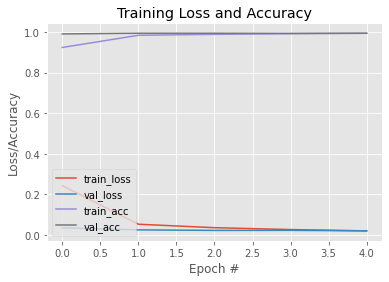

In [105]:
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), F.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), F.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), F.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), F.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig(args["plot"])